In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

# Verzeichnis mit unseren Trainingsdaten der Klasse 'car'
train_cars_dir = os.path.join('./data/vehicles')
test_cars_dir = os.path.join('./Test/vehicles')
validation_cars_dir = os.path.join('./Validation/vehicles')

# Verzeichnis mit unseren Trainingsdaten der Klasse 'nocar'
train_nocars_dir = os.path.join('./data/non-vehicles')
test_nocars_dir = os.path.join('./Test/non-vehicles')
validation_nocars_dir = os.path.join('./Validation/non-vehicles')



#train_cars_names = os.listdir(train_cars_dir)
#train_nocars_names = os.listdir(train_nocars_dir)

print('Anzahl Bilder im Verzeichnis Cars:', len(os.listdir(train_cars_dir)))
print('Anzahl Bilder im Verzeichnis no Cars:', len(os.listdir(train_nocars_dir)))

/Users/cristobalschmidt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Anzahl Bilder im Verzeichnis Cars: 14936
Anzahl Bilder im Verzeichnis no Cars: 10217


In [2]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(
        rescale = 1./255,
      rotation_range=180,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

# Zähle die Anzahl der Bilder im Trainingsverzeichnis
num_train_images = len(os.listdir(train_cars_dir)) + len(os.listdir(train_nocars_dir))

batchsize = 256
batchsize_val = 64
epochen = 5

# Berechne die Schritte pro Epoche
stepsperepoch = 1376
#int((num_train_images / batchsize)/20)

# Bilder aus dem Trainingsdatensatz fließen in Paketen (batches) von 128 in train_datagen
train_generator = train_datagen.flow_from_directory(
        './data/',  # Quellverzeichnis für Trainingsdaten
        target_size=(150, 150),  # Alle Bilder werden auf 300x300 Pixel skaliert
        batch_size=batchsize,
        # Konfiguriere Labels für eine binäre Klassifikation
        class_mode='binary')



# Bilder aus dem Trainingsdatensatz fließen in Paketen (batches) von 128 in train_datagen
validation_generator = validation_datagen.flow_from_directory(
        './Validation/',  # Quellverzeichnis für Trainingsdaten
        target_size=(150, 150),  # Alle Bilder werden auf 300x300 Pixel skaliert
        batch_size=batchsize_val,
        # Konfiguriere Labels für eine binäre Klassifikation
        class_mode='binary')

Found 25153 images belonging to 2 classes.
Found 9541 images belonging to 2 classes.


In [3]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [4]:
history = model.fit(
      train_generator,
      #steps_per_epoch=stepsperepoch,  
      epochs=epochen,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)


Epoch 1/5


/Users/cristobalschmidt/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9159 - loss: 0.3929 - val_accuracy: 0.9648 - val_loss: 0.0928
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9886 - loss: 0.0304 - val_accuracy: 0.9668 - val_loss: 0.0726
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9914 - loss: 0.0234 - val_accuracy: 0.9609 - val_loss: 0.0889
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9923 - loss: 0.0231 - val_accuracy: 0.9688 - val_loss: 0.1180
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 530s 5s/step - accuracy: 0.9924 - loss: 0.0228 - val_accuracy: 0.9707 - val_loss: 0.0724


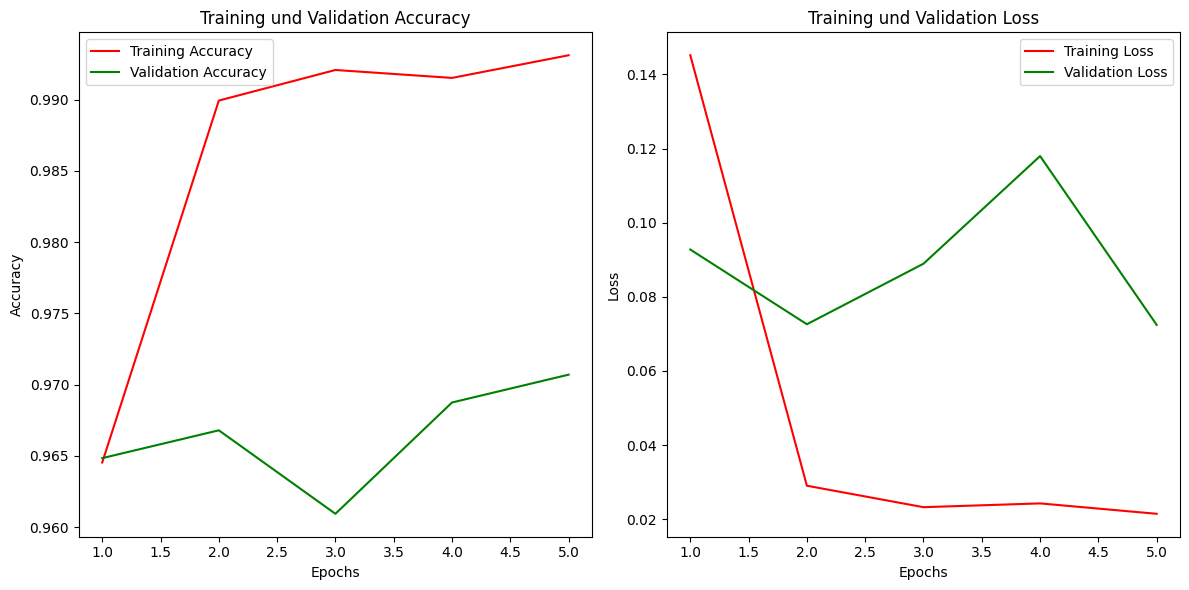

In [5]:
# Zugriff auf die Metriken aus dem history-Objekt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

for i in range(len(val_accuracy)):
    if val_accuracy[i] < 10e-8:
        if i < (len(val_accuracy)-1) and i > 0:
            val_accuracy[i] = (val_accuracy[i-1]+val_accuracy[i+1])/2
        elif i > 0:
            val_accuracy[i] = val_accuracy[i-1]
        else:
            val_accuracy[i] = val_accuracy[i+1]

    if val_loss[i] < 10e-8:
        if i < (len(val_accuracy)-1) and i>0:
            val_loss[i] = (val_loss[i-1]+val_loss[i+1])/2
        elif i > 0:
            val_loss[i] = val_loss[i-1]
        else:
            val_loss[i] = val_loss[i+1]


# Zugriff auf die Anzahl der Epochen
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training und Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training und Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Verzeichnis mit den Testdaten
test_dir = './Test/'

# ImageDataGenerator für Testdaten
test_datagen = ImageDataGenerator(rescale=1/255)

# Generator für Testdaten
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batchsize,
    class_mode='binary'
)

# Modell auf Testdaten evaluieren
eval_result = model.evaluate(test_generator)

# Ausgabe von Genauigkeit und Verlust
print("Test Genauigkeit:", eval_result[1])
print("Test Verlust:", eval_result[0])


Found 5406 images belonging to 2 classes.
22/22 ━━━━━━━━━━━━━━━━━━━━ 154s 7s/step - accuracy: 0.9985 - loss: 0.0035
Test Genauigkeit: 0.9987051486968994
Test Verlust: 0.003555881790816784


In [7]:
model.save('/Users/cristobalschmidt/DeepDrive2.0/h5_'+str(epochen)+'epochs_150x150.keras')